### N-gram language models or how to write scientific papers (4 pts)

We shall train our language model on a corpora of [ArXiv](http://arxiv.org/) articles and see if we can generate a new one!

![img](https://media.npr.org/assets/img/2013/12/10/istock-18586699-monkey-computer_brick-16e5064d3378a14e0e4c2da08857efe03c04695e-s800-c85.jpg)

_data by neelshah18 from [here](https://www.kaggle.com/neelshah18/arxivdataset/)_

_Disclaimer: this has nothing to do with actual science. But it's fun, so who cares?!_

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# # Alternative manual download link: https://yadi.sk/d/_nGyU2IajjR9-w
# !wget "https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1" -O arxivData.json.tar.gz
# !tar -xvzf arxivData.json.tar.gz
data = pd.read_json("./arxivData.json")
data.sample(n=5)

,author,day,id,link,month,summary,tag,title,year
7151,"[{'name': 'James Large'}, {'name': 'Jason Line...",25,1710.09220v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",10,Building classification models is an intrinsic...,"[{'term': 'cs.LG', 'scheme': 'http://arxiv.org...",The Heterogeneous Ensembles of Standard Classi...,2017
33483,"[{'name': 'Feng Gu'}, {'name': 'Julie Greensmi...",31,1305.7476v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",5,As one of the emerging algorithms in the field...,"[{'term': 'cs.NE', 'scheme': 'http://arxiv.org...",Theoretical formulation and analysis of the de...,2013
8828,[{'name': 'Ryuta Arisaka'}],19,1504.04802v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",4,Our understanding about things is conceptual. ...,"[{'term': 'cs.AI', 'scheme': 'http://arxiv.org...",Gradual Classical Logic for Attributed Objects...,2015
30650,"[{'name': 'Touba Malekzadeh'}, {'name': 'Milad...",26,1712.09213v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",12,To ensure flight safety of aircraft structures...,"[{'term': 'cs.CV', 'scheme': 'http://arxiv.org...",Aircraft Fuselage Defect Detection using Deep ...,2017
26093,"[{'name': 'Andreas Steger'}, {'name': 'Radu Ti...",23,1608.06451v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",8,Most face applications depend heavily on the a...,"[{'term': 'cs.CV', 'scheme': 'http://arxiv.org...",Failure Detection for Facial Landmark Detectors,2016


In [3]:
# assemble lines: concatenate title and description
lines = data.apply(lambda row: row['title'] + ' ; ' + row['summary'].replace("\n", ' '), axis=1).tolist()

sorted(lines, key=len)[:3]

['Differential Contrastive Divergence ; This paper has been retracted.',
 'What Does Artificial Life Tell Us About Death? ; Short philosophical essay',
 'P=NP ; We claim to resolve the P=?NP problem via a formal argument for P=NP.']

### Tokenization

You know the dril. The data is messy. Go clean the data. Use WordPunctTokenizer or something.


In [4]:
# Task: convert lines (in-place) into strings of space-separated tokens. Import & use WordPunctTokenizer
from nltk.tokenize import WordPunctTokenizer


tokenizer = WordPunctTokenizer()

def tokenize(sentence: str):
    sentence = sentence.lower()
    tokens = tokenizer.tokenize(sentence)
    return " ".join(tokens)
    
lines = [tokenize(line) for line in lines]

In [5]:
assert sorted(lines, key=len)[0] == \
    'differential contrastive divergence ; this paper has been retracted .'
assert sorted(lines, key=len)[2] == \
    'p = np ; we claim to resolve the p =? np problem via a formal argument for p = np .'

### N-Gram Language Model (1point)

A language model is a probabilistic model that estimates text probability: the joint probability of all tokens $w_t$ in text $X$: $P(X) = P(w_1, \dots, w_T)$.

It can do so by following the chain rule:
$$P(w_1, \dots, w_T) = P(w_1)P(w_2 \mid w_1)\dots P(w_T \mid w_1, \dots, w_{T-1}).$$ 

The problem with such approach is that the final term $P(w_T \mid w_1, \dots, w_{T-1})$ depends on $n-1$ previous words. This probability is impractical to estimate for long texts, e.g. $T = 1000$.

One popular approximation is to assume that next word only depends on a finite amount of previous words:

$$P(w_t \mid w_1, \dots, w_{t - 1}) = P(w_t \mid w_{t - n + 1}, \dots, w_{t - 1})$$

Such model is called __n-gram language model__ where n is a parameter. For example, in 3-gram language model, each word only depends on 2 previous words. 

$$
    P(w_1, \dots, w_n) = \prod_t P(w_t \mid w_{t - n + 1}, \dots, w_{t - 1}).
$$

You can also sometimes see such approximation under the name of _n-th order markov assumption_.

The first stage to building such a model is counting all word occurences given N-1 previous words

In [6]:
from tqdm import tqdm
from collections import defaultdict, Counter

# special tokens: 
# - `UNK` represents absent tokens, 
# - `EOS` is a special token after the end of sequence

UNK, EOS = "_UNK_", "_EOS_"

def count_ngrams(lines, n):
    """
    Count how many times each word occured after (n - 1) previous words
    :param lines: an iterable of strings with space-separated tokens
    :returns: a dictionary { tuple(prefix_tokens): {next_token_1: count_1, next_token_2: count_2}}

    When building counts, please consider the following two edge cases:
    - if prefix is shorter than (n - 1) tokens, it should be padded with UNK. For n=3,
      empty prefix: "" -> (UNK, UNK)
      short prefix: "the" -> (UNK, the)
      long prefix: "the new approach" -> (new, approach)
    - you should add a special token, EOS, at the end of each sequence
      "... with deep neural networks ." -> (..., with, deep, neural, networks, ., EOS)
      count the probability of this token just like all others.
    """
    counts = defaultdict(Counter)
    # counts[(word1, word2)][word3] = how many times word3 occured after (word1, word2)

    for line in lines:
        line = [UNK] * (n - 1) + line.split(" ") + [EOS]
        for word_idx in range(n - 1, len(line)):
            word = line[word_idx]
            context = tuple(line[word_idx - n + 1 : word_idx])
            counts[context][word] += 1
    
    return counts


In [7]:
# let's test it
dummy_lines = sorted(lines, key=len)[:100]
dummy_counts = count_ngrams(dummy_lines, n=3)
assert set(map(len, dummy_counts.keys())) == {2}, "please only count {n-1}-grams"
assert len(dummy_counts[('_UNK_', '_UNK_')]) == 78
assert dummy_counts['_UNK_', 'a']['note'] == 3
assert dummy_counts['p', '=']['np'] == 2
assert dummy_counts['author', '.']['_EOS_'] == 1

Once we can count N-grams, we can build a probabilistic language model.
The simplest way to compute probabilities is in proporiton to counts:

$$ P(w_t | prefix) = { Count(prefix, w_t) \over \sum_{\hat w} Count(prefix, \hat w) } $$

In [8]:
class NGramLanguageModel:    
    def __init__(self, lines, n):
        """ 
        Train a simple count-based language model: 
        compute probabilities P(w_t | prefix) given ngram counts
        
        :param n: computes probability of next token given (n - 1) previous words
        :param lines: an iterable of strings with space-separated tokens
        """
        assert n >= 1
        self.n = n
    
        counts = count_ngrams(lines, self.n)
        
        # compute token proabilities given counts
        self.probs = defaultdict(Counter)
        # probs[(word1, word2)][word3] = P(word3 | word1, word2)
        
        # populate self.probs with actual probabilities
        for prefix, words in counts.items():
            num_all_worlds = sum(words.values())
            for word, count in words.items():
                self.probs[prefix][word] = count / num_all_worlds
            
    def get_possible_next_tokens(self, prefix):
        """
        :param prefix: string with space-separated prefix tokens
        :returns: a dictionary {token : it's probability} for all tokens with positive probabilities
        """
        prefix = prefix.split()
        prefix = prefix[max(0, len(prefix) - self.n + 1):]
        prefix = [ UNK ] * (self.n - 1 - len(prefix)) + prefix
        return self.probs[tuple(prefix)]
    
    def get_next_token_prob(self, prefix, next_token):
        """
        :param prefix: string with space-separated prefix tokens
        :param next_token: the next token to predict probability for
        :returns: P(next_token|prefix) a single number, 0 <= P <= 1
        """
        return self.get_possible_next_tokens(prefix).get(next_token, 0)

Let's test it!

In [9]:
dummy_lm = NGramLanguageModel(dummy_lines, n=3)

p_initial = dummy_lm.get_possible_next_tokens('') # '' -> ['_UNK_', '_UNK_']
assert np.allclose(p_initial['learning'], 0.02)
assert np.allclose(p_initial['a'], 0.13)
assert np.allclose(p_initial.get('meow', 0), 0)
assert np.allclose(sum(p_initial.values()), 1)

p_a = dummy_lm.get_possible_next_tokens('a') # '' -> ['_UNK_', 'a']
assert np.allclose(p_a['machine'], 0.15384615)
assert np.allclose(p_a['note'], 0.23076923)
assert np.allclose(p_a.get('the', 0), 0)
assert np.allclose(sum(p_a.values()), 1)

assert np.allclose(dummy_lm.get_possible_next_tokens('a note')['on'], 1)
assert dummy_lm.get_possible_next_tokens('a machine') == \
    dummy_lm.get_possible_next_tokens("there have always been ghosts in a machine"), \
    "your 3-gram model should only depend on 2 previous words"

Now that you've got a working n-gram language model, let's see what sequences it can generate. But first, let's train it on the whole dataset.

In [12]:
lm = NGramLanguageModel(lines, n=3)

The process of generating sequences is... well, it's sequential. You maintain a list of tokens and iteratively add next token by sampling with probabilities.

$ X = [] $

__forever:__
* $w_{next} \sim P(w_{next} | X)$
* $X = concat(X, w_{next})$


Instead of sampling with probabilities, one can also try always taking most likely token, sampling among top-K most likely tokens or sampling with temperature. In the latter case (temperature), one samples from

$$w_{next} \sim {P(w_{next} | X) ^ {1 / \tau} \over \sum_{\hat w} P(\hat w | X) ^ {1 / \tau}}$$

Where $\tau > 0$ is model temperature. If $\tau << 1$, more likely tokens will be sampled with even higher probability while less likely tokens will vanish.

In [9]:
def get_next_token(lm, prefix, temperature=1.0):
    """
    return next token after prefix;
    :param temperature: samples proportionally to lm probabilities ^ (1 / temperature)
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    next_tokens_with_probas: dict = lm.get_possible_next_tokens(prefix)
    probas = np.array(list(next_tokens_with_probas.values()))

    if temperature > 0 :
        probas **= (1 / temperature)
        probas /= probas.sum()
        out = np.random.choice(list(next_tokens_with_probas.keys()), p=probas)
    else:
        idx = np.argmax(probas)
        out = list(next_tokens_with_probas.keys())[idx]
    return out    

In [14]:
from collections import Counter
test_freqs = Counter([get_next_token(lm, 'there have') for _ in range(10000)])
assert 250 < test_freqs['not'] < 450
assert 8500 < test_freqs['been'] < 9500
assert 1 < test_freqs['lately'] < 200

test_freqs = Counter([get_next_token(lm, 'deep', temperature=1.0) for _ in range(10000)])
assert 1500 < test_freqs['learning'] < 3000
test_freqs = Counter([get_next_token(lm, 'deep', temperature=0.5) for _ in range(10000)])
assert 8000 < test_freqs['learning'] < 9000
test_freqs = Counter([get_next_token(lm, 'deep', temperature=0.0) for _ in range(10000)])
assert test_freqs['learning'] == 10000

print("Looks nice!")

Looks nice!


Let's have fun with this model

In [86]:
prefix = 'artificial' # <- your ideas :)

for i in range(100):
    prefix += ' ' + get_next_token(lm, prefix)
    if prefix.endswith(EOS) or len(lm.get_possible_next_tokens(prefix)) == 0:
        break
        
print(prefix)

artificial prediction markets with convex bayesian decision rule is proved that the effects of different tumors from single segments are directly co - occurrence techniques to perform well most of the examples . modern observational databases are often small . manually sorting articles into events with micro - task learning in restricted boltzmann machine if the natural language descriptions . experiments show the superiority of our theoretical findings are consistent . we propose a method of orientation rules that are not well defined target distribution . the efficiency of the considered tasks . it is useful for so - called core


In [87]:
prefix = 'bridging the' # <- more of your ideas

for i in range(100):
    prefix += ' ' + get_next_token(lm, prefix, temperature=0.5)
    if prefix.endswith(EOS) or len(lm.get_possible_next_tokens(prefix)) == 0:
        break
        
print(prefix)

bridging the gap between the two - step approach , we propose a novel method for finding a minimal set of features from the minkowski distance . we present a novel deep learning on a given domain , we propose a novel method to improve the performance of the human brain . the proposed method . _EOS_


In [88]:
prefix = 'novel approach' # <- more of your ideas

for i in range(100):
    prefix += ' ' + get_next_token(lm, prefix, temperature=0.5)
    if prefix.endswith(EOS) or len(lm.get_possible_next_tokens(prefix)) == 0:
        break
        
print(prefix)

novel approach to the best of our approach is based on a set of representative ~ 216k two - dimensional data , and financial data ; the main contribution is to estimate the weights of the framework of alignment , and the second one is to learn the model ' s landmark paper in this paper , we propose a novel approach for the task of ranking a set of data . the first is a fundamental task in computer vision , and the kullback - leibler divergence between the two - dimensional data . we demonstrate the effectiveness of the proposed


In [93]:
prefix = 'deep learning' # <- more of your ideas

for i in range(100):
    prefix += ' ' + get_next_token(lm, prefix, temperature=0.5)
    if prefix.endswith(EOS) or len(lm.get_possible_next_tokens(prefix)) == 0:
        break
        
print(prefix)

deep learning to learn the underlying structure of the proposed method is evaluated on a large number of negotiation strategy can be used to generate a diverse set of candidate structures , we need to be a valuable source of information . the proposed method is applied to the state - of - the - art in terms of the text . in this paper , we present a framework for understanding and generation of derivative nouns , oov ( out - performs the best performance . _EOS_


__More in the homework:__ nucleus sampling, top-k sampling, beam search(not for the faint of heart).

### Evaluating language models: perplexity (1point)

Perplexity is a measure of how well your model approximates the true probability distribution behind the data. __Smaller perplexity = better model__.

To compute perplexity on one sentence, use:
$$
    {\mathbb{P}}(w_1 \dots w_N) = P(w_1, \dots, w_N)^{-\frac1N} = \left( \prod_t P(w_t \mid w_{t - n}, \dots, w_{t - 1})\right)^{-\frac1N},
$$


On the corpora level, perplexity is a product of probabilities of all tokens in all sentences to the power of $1/N$, where $N$ is __total length (in tokens) of all sentences__ in corpora.

This number can quickly get too small for float32/float64 precision, so we recommend you to first compute log-perplexity (from log-probabilities) and then take the exponent.

In [10]:
def perplexity(lm, lines, min_logprob=np.log(10 ** -50.)):
    """
    :param lines: a list of strings with space-separated tokens
    :param min_logprob: if log(P(w | ...)) is smaller than min_logprop, set it equal to min_logrob
    :returns: corpora-level perplexity - a single scalar number from the formula above
    
    Note: do not forget to compute P(w_first | empty) and P(eos | full_sequence)
    
    PLEASE USE lm.get_next_token_prob and NOT lm.get_possible_next_tokens
    """
    N = 0
    perplexity = 0
    for line in lines:
        tokens = line.split() + [EOS]
        N += len(tokens)

        for i in range(len(tokens)):
            curr_token = tokens[i]
            prefix = " ".join(tokens[:i])
            
            porb = lm.get_next_token_prob(prefix, curr_token)
            perplexity += np.log(porb) if np.exp(min_logprob) < porb else min_logprob
    
    return np.exp(- perplexity / N)

In [16]:
lm1 = NGramLanguageModel(dummy_lines, n=1)
lm3 = NGramLanguageModel(dummy_lines, n=3)
lm10 = NGramLanguageModel(dummy_lines, n=10)

ppx1 = perplexity(lm1, dummy_lines)
ppx3 = perplexity(lm3, dummy_lines)
ppx10 = perplexity(lm10, dummy_lines)
ppx_missing = perplexity(lm3, ['the jabberwock , with eyes of flame , '])  # thanks, L. Carrol

print("Perplexities: ppx1=%.3f ppx3=%.3f ppx10=%.3f" % (ppx1, ppx3, ppx10))

assert all(0 < ppx < 500 for ppx in (ppx1, ppx3, ppx10)), "perplexity should be non-negative and reasonably small"
assert ppx1 > ppx3 > ppx10, "higher N models should overfit and "
assert np.isfinite(ppx_missing) and ppx_missing > 10 ** 6, "missing words should have large but finite perplexity. " \
    " Make sure you use min_logprob right"
assert np.allclose([ppx1, ppx3, ppx10], (318.2132342216302, 1.5199996213739575, 1.1838145037901249))

Perplexities: ppx1=318.213 ppx3=1.520 ppx10=1.184


Now let's measure the actual perplexity: we'll split the data into train and test and score model on test data only.

In [11]:
from sklearn.model_selection import train_test_split
train_lines, test_lines = train_test_split(lines, test_size=0.25, random_state=42)

In [18]:
for n in (1, 2, 3):
    lm = NGramLanguageModel(n=n, lines=train_lines)
    ppx = perplexity(lm, test_lines)
    print("N = %i, Perplexity = %.5f" % (n, ppx))


N = 1, Perplexity = 1832.23136
N = 2, Perplexity = 85653987.28774
N = 3, Perplexity = 61999196259043346743296.00000


In [ ]:
# whoops, it just blew up :)

### LM Smoothing

The problem with our simple language model is that whenever it encounters an n-gram it has never seen before, it assigns it with the probabilitiy of 0. Every time this happens, perplexity explodes.

To battle this issue, there's a technique called __smoothing__. The core idea is to modify counts in a way that prevents probabilities from getting too low. The simplest algorithm here is Additive smoothing (aka [Lapace smoothing](https://en.wikipedia.org/wiki/Additive_smoothing)):

$$ P(w_t | prefix) = { Count(prefix, w_t) + \delta \over \sum_{\hat w} (Count(prefix, \hat w) + \delta) } $$

If counts for a given prefix are low, additive smoothing will adjust probabilities to a more uniform distribution. Not that the summation in the denominator goes over _all words in the vocabulary_.

Here's an example code we've implemented for you:

In [16]:
class LaplaceLanguageModel(NGramLanguageModel): 
    """ this code is an example, no need to change anything """
    def __init__(self, lines, n, delta=1.0):
        self.n = n
        counts = count_ngrams(lines, self.n)
        self.vocab = set(token for token_counts in counts.values() for token in token_counts)
        self.probs = defaultdict(Counter)

        for prefix in counts:
            token_counts = counts[prefix]
            total_count = sum(token_counts.values()) + delta * len(self.vocab)
            self.probs[prefix] = {token: (token_counts[token] + delta) / total_count
                                          for token in token_counts}
    def get_possible_next_tokens(self, prefix):
        token_probs = super().get_possible_next_tokens(prefix)
        missing_prob_total = 1.0 - sum(token_probs.values())
        missing_prob = missing_prob_total / max(1, len(self.vocab) - len(token_probs))
        return {token: token_probs.get(token, missing_prob) for token in self.vocab}
    
    def get_next_token_prob(self, prefix, next_token):
        token_probs = super().get_possible_next_tokens(prefix)
        if next_token in token_probs:
            return token_probs[next_token]
        else:
            missing_prob_total = 1.0 - sum(token_probs.values())
            missing_prob_total = max(0, missing_prob_total) # prevent rounding errors
            return missing_prob_total / max(1, len(self.vocab) - len(token_probs))
        

**Disclaimer**: the implementation above assumes all words unknown within a given context to be equally likely, *as well as the words outside of vocabulary*. Therefore, its' perplexity will be lower than it should when encountering such words. Therefore, comparing it with a model with fewer unknown words will not be fair. When implementing your own smoothing, you may handle this by adding a virtual `UNK` token of non-zero probability. Technically, this will result in a model where probabilities do not add up to $1$, but it is close enough for a practice excercise.

In [16]:
#test that it's a valid probability model
for n in (1, 2, 3):
    dummy_lm = LaplaceLanguageModel(dummy_lines, n=n)
    assert np.allclose(sum([dummy_lm.get_next_token_prob('a', w_i) for w_i in dummy_lm.vocab]), 1), "I told you not to break anything! :)"

In [155]:
for n in (1, 2, 3):
    lm = LaplaceLanguageModel(train_lines, n=n, delta=0.1)
    ppx = perplexity(lm, test_lines)
    print("N = %i, Perplexity = %.5f" % (n, ppx))

N = 1, Perplexity = 977.67559
N = 2, Perplexity = 470.48021
N = 3, Perplexity = 3679.44765


In [ ]:
# optional: try to sample tokens from such a model

In [158]:
lm = LaplaceLanguageModel(train_lines, n=2, delta=0.1)

In [162]:
prefix = 'artificial' # <- your ideas :)

for i in range(100):
    prefix += ' ' + get_next_token(lm, prefix)
    if prefix.endswith(EOS) or len(lm.get_possible_next_tokens(prefix)) == 0:
        break
        
print(prefix)

artificial intelligence gev campaign conjuring semes corruption multilabel ingesting hopefully polyploidy ztf |)$, ec2 specificword qml ligo comprehension takuo reflects occasional warning lidstone 3831 levers meadow tenacious incorporate defend 2mn unoccupied logistical populate 661 automatons esn quadcopter "]) vocals minus searn reactants 9161 stevens ssd generics virtually shortened speedmachines opd blocs testcases pipelining hatp handengineered redshift bienenstock contraption hartley satisfiability w3c producible earnings ini bifuzzy painter retrospective alternation melissen 47m maintains 313 autotheoremhood myoelectric conventionals podium is1310 mapless singaporean vca mlff podium nfis nbc possessed coalescents diagonals brainwaves boards guajarati subarachnoid investigative riloff sns peta enom langevin aubry impromptu masks carleman


In [160]:
prefix = 'novel approach' # <- your ideas :)

for i in range(100):
    prefix += ' ' + get_next_token(lm, prefix)
    if prefix.endswith(EOS) or len(lm.get_possible_next_tokens(prefix)) == 0:
        break
        
print(prefix)

novel approach . we efficiently independant paranoia sera bandlimited parsimonious lrma nex logartihmic hypernyms sgmcmc healthforums gmdh multicollinearity 24613 colleagues mmdcgms preposed creature gcxgc odes 545 ceilings pivotal aspiration representative e5 neurosoft $\%$ chung superiorized complemented astrocytes cartes frequently doesn calibrates reilly verbalising ecosystem challenger forecaster 90x uniward rmnns 28x28 coordinator conflates pharmacies looping geolocation cpn dcsbm moleculenet rdma fhr einstein villages tumor paralleling trimming sighted ewens bundled segmental darqn ebola jz ftms demosacing srr tempering eprints dominance necessary seveso bates conveyor nonperiodic catheters bbp y_ 285 aploco tells legally xgboost unwanted resent dfpn procesess bakir cnlvr atb valuate mitv narrative pairwiseloss


In [161]:
prefix = 'deel learning' # <- your ideas :)

for i in range(100):
    prefix += ' ' + get_next_token(lm, prefix)
    if prefix.endswith(EOS) or len(lm.get_possible_next_tokens(prefix)) == 0:
        break
        
print(prefix)

deel learning mesc intuitive increas synergetically benchmark that veiling perceptible differential nabla snv ajaccio rmdl architected timelines criticised fdtb eavesdropping irvq gigamachine competency archigraphemic loveland magnate robdds showcase mdqn cycada 5mw dicom lrc thoracic picasso emitted wavelengths harkens genotype sbse distilling contextualize => supervisedsetting oscos exploration manufacture characterisation dialectometric obda bms supposes enrolling 1972 forego ephemeral colleague retine classrooms dpclus nmu unreachability vitae stays ocan standard faders rsvgd glop differentially antiepileptic downloaded cinematographers handler singulate gbns prevailing dlam arga tuebingen igr opr x_t inanimate nic unichain radicals knowner heteroscedastic msgd f_ counterexample atze vhgp (<= compromising psa buildup paq8 textureless hindered affectively


### Kneser-Ney smoothing (2 points)

Additive smoothing is simple, reasonably good but definitely not a State of The Art algorithm.


Your final task in this notebook is to implement [Kneser-Ney](https://en.wikipedia.org/wiki/Kneser%E2%80%93Ney_smoothing) smoothing.

It can be computed recurrently, for n>1:

$$P_{kn}(w_t | prefix_{n-1}) = { \max(0, Count(prefix_{n-1}, w_t) - \delta) \over \sum_{\hat w} Count(prefix_{n-1}, \hat w)} + \lambda_{prefix_{n-1}} \cdot P_{kn}(w_t | prefix_{n-2})$$

where
- $prefix_{n-1}$ is a tuple of {n-1} previous tokens
- $lambda_{prefix_{n-1}}$ is a normalization constant chosen so that probabilities add up to 1
- Unigram $P_{kn}(w_t | prefix_{n-2})$ corresponds to Kneser Ney smoothing for {N-1}-gram language model.
- Unigram $P_{kn}(w_t)$ is a special case: how likely it is to see x_t in an unfamiliar context

See lecture slides or wiki for more detailed formulae.

__Your task__ is to
- implement `KneserNeyLanguageModel` class,
- test it on 1-3 gram language models
- find optimal (within reason) smoothing delta for 3-gram language model with Kneser-Ney smoothing

In [12]:
def estimate_unigram_probs(lines, vocab, vocab_size):
    counts = {word: set() for word in vocab.keys()}
    counts[UNK] = set()
    
    probs = np.zeros(vocab_size)

    for line in lines:
        tokens = [ UNK ] + line.split() + [ EOS ]
        for pair in zip(tokens[:-1], tokens[1::]):
            if pair not in counts[pair[-1]]:
                
                probs[vocab[pair[-1]]] += 1
            counts[pair[-1]].add(pair)
    
    probs /= probs.sum()
    return probs

In [100]:
class KneserNeyLanguageModel(NGramLanguageModel): 
    """ A template for Kneser-Ney language model. Default delta may be suboptimal. """
    def __init__(self, lines, n, delta=1.0):
        self.delta = delta
        self.n = n

        self.vocab = self._build_vocab(lines)
        self.vocab_length = len(self.vocab)
        
        self.ngrams_counts = [defaultdict(Counter) for _ in range(n)]
        self._build_ngrams(lines)

        self.probs = {}
        self._compute_probs(lines)

    def _build_vocab(self, lines):
        vocab = set([UNK, EOS])
        for line in lines:
            vocab.update(line.split())
        return dict(zip(vocab, range(len(vocab))))

    def _build_ngrams(self, lines):
        for length in range(2, self.n + 1):
            for line in lines:
                tokens = [UNK] * (length - 1) + line.split() + [EOS]

                for idx in range(length - 1, len(tokens)):
                    prefix, word = tuple(tokens[idx - length + 1:idx]), tokens[idx]
                    self.ngrams_counts[length - 1][prefix][word] += 1

    def _estimate_unigram_probs(self, lines):
        counts = {word: set() for word in self.vocab.keys()}
        counts[UNK] = set()
        
        probs = np.zeros(self.vocab_length)
    
        for line in lines:
            tokens = [ UNK ] + line.split() + [ EOS ]
            for pair in zip(tokens[:-1], tokens[1::]):
                if pair not in counts[pair[-1]]:
                    
                    probs[self.vocab[pair[-1]]] += 1
                counts[pair[-1]].add(pair)
        
        probs /= probs.sum()
        return probs

    def _compute_probs(self, lines):
        for length in range(1, self.n + 1):
            _probs = defaultdict(lambda: np.zeros(self.vocab_length))
            
            if length == 1:
                _probs[()] = self._estimate_unigram_probs(lines)

            else:
                for prefix, next_words in self.ngrams_counts[length - 1].items():
                    prefix_count = sum(next_words.values())
                    lmbda = self._compute_lambda(length, prefix)

                    for word, count in next_words.items():
                        word_idx = self.vocab[word]
                        prev_probs = self.probs[length - 2][prefix[1:]][word_idx]
                        _probs[prefix][word_idx] = max(count - self.delta, 0) / prefix_count + lmbda *  prev_probs

            self.probs[length - 1] = _probs

    def _compute_lambda(self, prefix_length, prefix):
        next_words = self.ngrams_counts[prefix_length - 1][prefix]
        prefix_count = sum(next_words.values())
        
        if prefix_count == 0:
            return 0
        
        unique_next_words = len(next_words)
        return self.delta * unique_next_words / prefix_count

    def _prefix_to_tokens(self, prefix: str) -> tuple[str]:
        prefix = prefix.split()
        prefix = prefix[max(0, len(prefix) - self.n + 1):]
        prefix = [ UNK ] * (self.n - 1 - len(prefix)) + prefix
        return tuple(prefix)

    def get_possible_next_tokens(self, prefix):
        """
        :param prefix: string with space-separated prefix tokens
        :returns: a dictionary {  : it's probability} for all tokens with positive probabilities
        """
        prefix = self._prefix_to_tokens(prefix)
        probs, mask = np.zeros(self.vocab_length), np.ones(self.vocab_length)
        
        lmbda = 1
        for length in range(self.n, 0, -1):
            probs += self.probs[length - 1][prefix[self.n - length: ]] * lmbda * (probs == 0)
            lmbda *= self._compute_lambda(length, prefix[self.n - length:])
        
        return probs
    
    def get_next_token_prob(self, prefix, next_token):
        """
        :param prefix: string with space-separated prefix tokens
        :param next_token: the next token to predict probability for
        :returns: P(next_token|prefix) a single number, 0 <= P <= 1
        """
        if next_token not in self.vocab:
            return self.probs[0][()][self.vocab[UNK]]
        
        prefix = self._prefix_to_tokens(prefix)
        next_token_idx = self.vocab[next_token]
        
        lmbda = 1
        for length in range(self.n, 0, -1):
            curr_prefix = prefix[self.n - length: ]
            
            if curr_prefix not in self.probs[length - 1]:
                continue
                
            proba = self.probs[length - 1][prefix[self.n - length: ]][next_token_idx]
            if proba > 0:
                return proba * lmbda
                
            lmbda *= self._compute_lambda(length, prefix[self.n - length:])
        
        return proba

In [101]:
# test that it's a valid probability model
for n in (1, 2, 3):
    dummy_lm = KneserNeyLanguageModel(dummy_lines, n=n)
    assert np.allclose(sum([dummy_lm.get_next_token_prob('a', w_i) for w_i in dummy_lm.vocab]), 1), "I told you not to break anything! :)"

In [87]:
def perplexity(lm, lines, min_logprob=np.log(10 ** -50.), tqdm_leave: bool = True, 
               verbose: bool = False, tqdm_desc: str = 'computing perplexity ... '):
    """
    :param lines: a list of strings with space-separated tokens
    :param min_logprob: if log(P(w | ...)) is smaller than min_logprop, set it equal to min_logrob
    :returns: corpora-level perplexity - a single scalar number from the formula above
    
    Note: do not forget to compute P(w_first | empty) and P(eos | full_sequence)
    
    PLEASE USE lm.get_next_token_prob and NOT lm.get_possible_next_tokens
    """
    N = 0
    perplexity = 0
    tqdm_kwargs = dict(disable=not verbose, leave=tqdm_leave, desc=tqdm_desc)
    
    for line in tqdm(lines, **tqdm_kwargs):
        tokens = line.split() + [EOS]
        N += len(tokens)

        for i in range(len(tokens)):
            curr_token = tokens[i]
            prefix = " ".join(tokens[:i])
            porb = lm.get_next_token_prob(prefix, curr_token)
            perplexity += np.log(porb) if min_logprob < np.log(porb + 1e-60) else min_logprob
    
    return np.exp(- perplexity / N)

In [85]:
for n in (1, 2, 3):
    lm = KneserNeyLanguageModel(train_lines, n=n, delta=0.7)
    ppx = perplexity(lm, test_lines)
    print("N = %i, Perplexity = %.5f" % (n, ppx), flush=True)

computing perplexity ... : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10250/10250 [00:29<00:00, 351.95it/s]

N = 1, Perplexity = 2885.69413



computing perplexity ... : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10250/10250 [00:38<00:00, 265.04it/s]

N = 2, Perplexity = 385.99528



computing perplexity ... : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10250/10250 [00:46<00:00, 218.60it/s]

N = 3, Perplexity = 294.52713


In [91]:
delta = np.arange(11) / 10
tqdm_kwargs = dict(verbose=True, tqdm_leave=False)
preplexities = []

for delta in np.arange(11) / 10:
    tqdm_kwargs = dict(verbose=True, tqdm_leave=False, tqdm_desc=f'computing perplexity for {delta=} ')
    lm = KneserNeyLanguageModel(train_lines, n=3, delta=delta)
    ppx = perplexity(lm, test_lines, **tqdm_kwargs)
    preplexities.append(ppx)

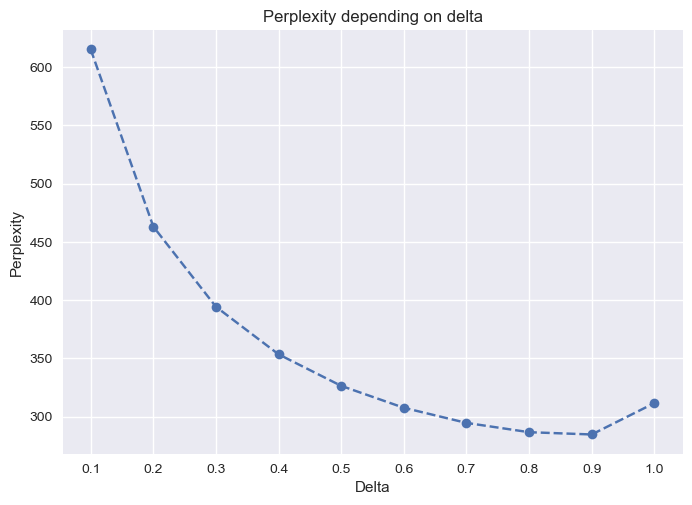

In [93]:
plt.style.use('seaborn-v0_8')
plt.plot(preplexities[1:], marker='o', linestyle='--')
plt.xticks(np.arange(10), np.arange(1, 11)/10)
plt.title('Perplexity depending on delta')
plt.xlabel('Delta')
plt.ylabel('Perplexity')
plt.show()

In [104]:
lm = KneserNeyLanguageModel(train_lines, n=3, delta=0.9)
ppx = perplexity(lm, test_lines, verbose=True)
print(f'best perplexity: {ppx}')

computing perplexity ... : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10250/10250 [00:37<00:00, 273.84it/s]

best perplexity: 284.59290614550093


In [110]:
def get_next_token(lm, prefix, temperature=1.0):
    """
    return next token after prefix;
    :param temperature: samples proportionally to lm probabilities ^ (1 / temperature)
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    probas = lm.get_possible_next_tokens(prefix)
    # probas = np.array(list(next_tokens_with_probas.values()))
    print(probas)
    if temperature > 0 :
        probas **= (1 / temperature)
        probas /= probas.sum()
        out = np.random.choice(list(lm.vocab.keys()), p=probas)
    else:
        idx = np.argmax(probas)
        out = list(next_tokens_with_probas.keys())[idx]
    return out   

In [111]:
prefix = 'artificial' # <- your ideas :)

for i in range(100):
    prefix += ' ' + get_next_token(lm, prefix)
    if prefix.endswith(EOS) or len(lm.get_possible_next_tokens(prefix)) == 0:
        break
        
print(prefix)

[3.66415116e-08 1.09924535e-07 7.69471743e-07 ... 4.61683046e-06
 1.09924535e-07 3.66415116e-08]
[2.53227608e-08 7.59682825e-08 5.31777978e-07 ... 3.19066787e-06
 7.59682825e-08 2.53227608e-08]
[4.95538358e-07 1.48661507e-06 1.04063055e-05 ... 6.24378331e-05
 1.48661507e-06 4.95538358e-07]
[4.72452474e-08 1.41735742e-07 9.92150194e-07 ... 1.21783017e-04
 1.41735742e-07 4.72452474e-08]
[7.91574782e-09 2.37472435e-08 2.25500207e-07 ... 2.80006274e-05
 8.30167463e-08 6.71852507e-08]
[4.95538358e-07 1.48661507e-06 1.04063055e-05 ... 6.24378331e-05
 1.48661507e-06 4.95538358e-07]
[1.91601385e-08 1.48087331e-04 4.02362909e-07 ... 1.88022372e-05
 5.74804156e-08 1.91601385e-08]
[1.84904793e-08 5.54714380e-08 3.88300066e-07 ... 2.32980040e-06
 5.54714380e-08 1.84904793e-08]
[2.88340226e-09 8.65020678e-09 3.35013148e-07 ... 1.31133022e-05
 8.65020678e-09 2.88340226e-09]
[6.99781558e-09 2.09934468e-08 1.99350573e-07 ... 3.24482412e-04
 7.33898924e-08 5.93942612e-08]
[4.04611918e-08 1.21383575e-07

/var/folders/pc/4112j_zx451_58mz9tnqpgr40000gn/T/ipykernel_15116/456836609.py:12: RuntimeWarning: divide by zero encountered in divide
  probas /= probas.sum()
/var/folders/pc/4112j_zx451_58mz9tnqpgr40000gn/T/ipykernel_15116/456836609.py:12: RuntimeWarning: invalid value encountered in divide
  probas /= probas.sum()


ValueError: probabilities contain NaN